In [1]:
%pylab inline
figsize(8, 6)

Populating the interactive namespace from numpy and matplotlib


##Import

In [2]:
import pandas
import numexpr
import numpy
from rep_ef.estimators import MatrixNetSkyGridClassifier
from rep.metaml import FoldingClassifier
from rep.data import LabeledDataStorage
from rep.report import ClassificationReport
from rep.report.metrics import RocAuc

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

In [3]:
from utils import get_N_B_events, get_events_number, get_events_statistics

## Reading initial data

In [4]:
data_nan = pandas.read_csv('datasets/Tracks.csv', sep='\t')

In [5]:
data_nan.head()

,run,event,Bmass,i,mult,partP,partPt,ptB,IPs,IP,...,proj,ID,veloch,signB,signTrack,Dist_phi,N_sig_sw,mu_cut,e_cut,K_cut
0,115839,204997902,5.309576,0,13,3.67156,0.300418,4.004197,0.816143,0.056365,...,1.058442,-211,0.911645,1,-1,0.114615,0.59521,0,0,0
1,115839,204997902,5.309576,1,13,8.33952,1.103876,4.004197,1.375382,0.033095,...,3.121358,-211,0.796731,1,-1,0.051334,0.59521,0,0,0
2,115839,204997902,5.309576,2,13,8.37654,1.182519,4.004197,4.338812,0.077636,...,10.585135,-211,0.946629,1,-1,1.856516,0.59521,0,0,0
3,115839,204997902,5.309576,3,13,25.72961,0.905010,4.004197,2.287509,0.086603,...,7.485243,211,1.058989,1,1,0.577419,0.59521,0,0,0
4,115839,204997902,5.309576,4,13,3.70597,0.516123,4.004197,0.562424,0.015694,...,5.617354,211,1.042135,1,1,1.314513,0.59521,0,0,0


In [6]:
event_id_column = 'event_id'
data_nan[event_id_column] = data_nan.run.apply(str) + '_' + data_nan.event.apply(str)

In [7]:
get_events_statistics(data_nan)

{'Events': 1005757, 'tracks': 27156193}

In [8]:
get_N_B_events()

742867.7142562866

## Remove rows with NAN from data

In [9]:
data = data_nan.dropna()
len(data_nan), len(data), get_events_statistics(data)

(27156193, 27156190, {'Events': 1005757, 'tracks': 27156190})

## Add diff_pt and cos(diff_phi)

In [10]:
# add different between max pt in event and pt for each track
def add_diff_pt(data):
    max_pt = group_max(data[event_id_column].values.astype(str), data.partPt.values)
    data['diff_pt'] = max_pt - data['partPt'].values

# max is computing max over tracks in the same event for saome data
def group_max(groups, data):
    # computing unique integer id for each group
    assert len(groups) == len(data)
    _, event_id = numpy.unique(groups, return_inverse=True)
    max_over_event = numpy.zeros(max(event_id) + 1) - numpy.inf
    numpy.maximum.at(max_over_event, event_id, data)
    return max_over_event[event_id]

In [11]:
# add diff pt
add_diff_pt(data)
# add cos(diff_phi)
data['cos_diff_phi'] = numpy.cos(data.diff_phi.values)

## Add max, sum among PIDs

In [12]:
from itertools import combinations
PIDs = {'k': data.PIDNNk.values,
        'e': data.PIDNNe.values,
        'mu': data.PIDNNm.values,
       }
for (pid_name1, pid_values1), (pid_name2, pid_values2) in combinations(PIDs.items(), 2):
    data['max_PID_{}_{}'.format(pid_name1, pid_name2)] = numpy.maximum(pid_values1, pid_values2)
    data['sum_PID_{}_{}'.format(pid_name1, pid_name2)] = pid_values1 + pid_values2

## define `label` = `signB` * `signTrack`

* if > 0 (same sign) - label **1**
* if < 0 (different sign) - label **0**

In [13]:
data['label'] = (data.signB.values * data.signTrack.values > 0) * 1

In [14]:
','.join(data.columns)

'run,event,Bmass,i,mult,partP,partPt,ptB,IPs,IP,IPerr,partlcs,EOverP,ghostProb,IPPU,nnkrec,PIDNNk,PIDNNpi,PIDNNp,PIDNNm,PIDNNe,diff_eta,diff_phi,phi,eta,proj,ID,veloch,signB,signTrack,Dist_phi,N_sig_sw,mu_cut,e_cut,K_cut,event_id,diff_pt,cos_diff_phi,max_PID_mu_k,sum_PID_mu_k,max_PID_mu_e,sum_PID_mu_e,max_PID_k_e,sum_PID_k_e,label'

## Filter out protons and pions, apply ghost prob cut

In [15]:
threshold_mistag = 0.6
initial_cut = '(PIDNNpi < {tr}) & (ghostProb < 0.4)'.format(tr=threshold_mistag)
data = data.query(initial_cut)

In [16]:
get_events_statistics(data)

{'Events': 998063, 'tracks': 9728403}

## Leave muons, kaons, electrons

In [17]:
threshold_kaon = 0.1 
threshold_muon = 0.1
threshold_electron = 0.1
cut_pid = " ( (PIDNNk > {trk}) | (PIDNNm > {trm}) | (PIDNNe > {tre}) ) "
cut_pid = cut_pid.format(trk=threshold_kaon, trm=threshold_muon, tre=threshold_electron)
    
data = data.query(cut_pid)

In [18]:
get_events_statistics(data)

{'Events': 971135, 'tracks': 4746037}

## Calculating tagging efficiency ($\epsilon_{tag}$)

$$N (\text{passed selection}) = \sum_{\text{passed selection}} sw_i$$

$$N (\text{all events}) = \sum_{\text{all events}} sw_i,$$

where $sw_i$ - sPLot weight (sWeight for signal)

$$\epsilon_{tag} = \frac{N (\text{passed selection})} {N (\text{all events})}$$

$$\Delta\epsilon_{tag} = \frac{\sqrt{N (\text{passed selection})}} {N (\text{all events})}$$

In [19]:
N_B_passed = float(get_events_number(data))
tagging_efficiency = N_B_passed / get_N_B_events()
tagging_efficiency_delta = sqrt(N_B_passed) / get_N_B_events()
tagging_efficiency, tagging_efficiency_delta

(0.9652542942247968, 0.0011398957363784664)

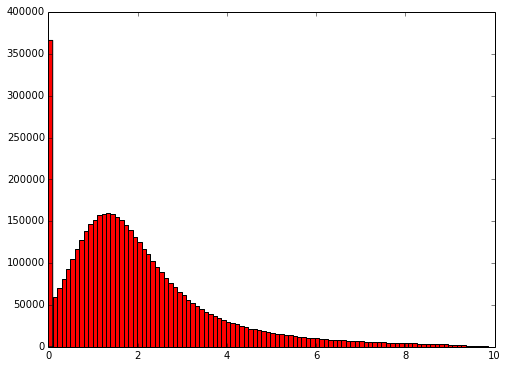

In [20]:
hist(data.diff_pt.values, bins=100)
pass

## Choose most probable B-events

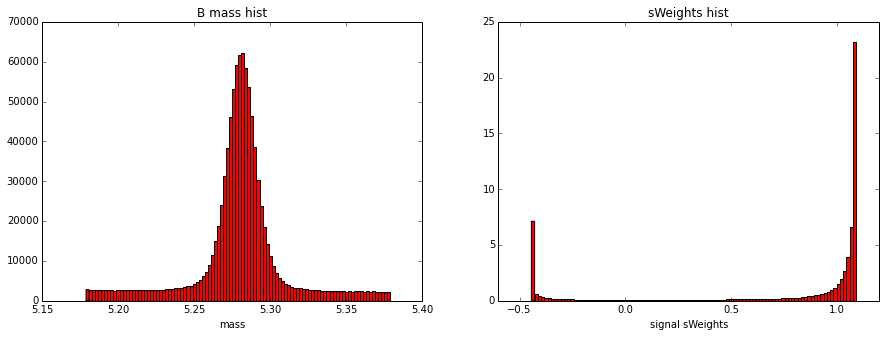

In [21]:
_, take_indices = numpy.unique(data[event_id_column], return_index=True)

figure(figsize=[15, 5])

subplot(1, 2, 1)
hist(data.Bmass.values[take_indices], bins=100)
title('B mass hist')
xlabel('mass')

subplot(1, 2, 2)
hist(data.N_sig_sw.values[take_indices], bins=100, normed=True)
title('sWeights hist')
xlabel('signal sWeights')
plt.savefig('img/Bmass.png' , format='png')

### Define B-like events for training 

Events with low sWeight still will be used only to test quality.

In [22]:
sweight_threshold = 1.
data_sw_passed = data[data.N_sig_sw > sweight_threshold]
data_sw_not_passed = data[data.N_sig_sw <= sweight_threshold]
get_events_statistics(data_sw_passed)

{'Events': 592979, 'tracks': 2846089}

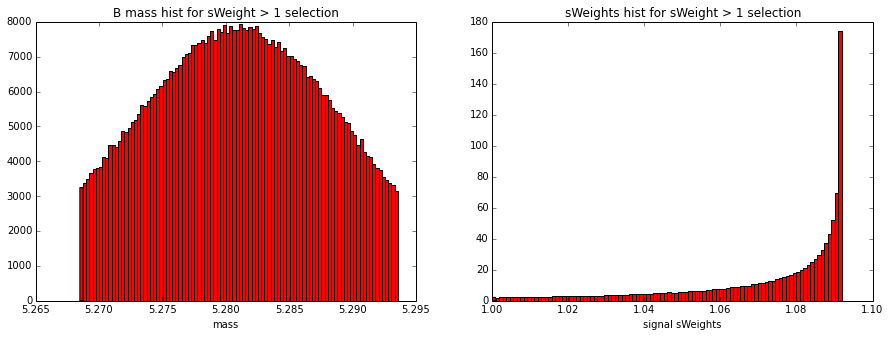

In [23]:
_, take_indices = numpy.unique(data_sw_passed[event_id_column], return_index=True)

figure(figsize=[15, 5])
subplot(1, 2, 1)
hist(data_sw_passed.Bmass.values[take_indices], bins=100)
title('B mass hist for sWeight > 1 selection')
xlabel('mass')

subplot(1, 2, 2)
hist(data_sw_passed.N_sig_sw.values[take_indices], bins=100, normed=True)
title('sWeights hist for sWeight > 1 selection')
xlabel('signal sWeights')
plt.savefig('img/Bmass_selected.png' , format='png')

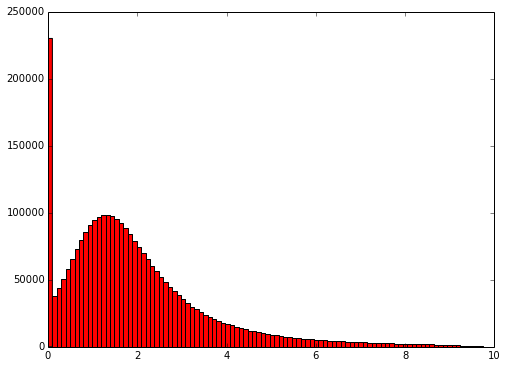

In [24]:
hist(data_sw_passed.diff_pt.values, bins=100)
pass

# Main idea: 
## find tracks, which can help reconstruct the sign of B if you know track sign.

`label` = `signB` * `signTrack`
* the highest output means that this is same sign B as track
* the lowest output means that this is opposite sign B than track

## Define features

In [25]:
features = list(set(data.columns) - {'run', 'event', 'i', 'signB', 'signTrack', 'N_sig_sw', 'Bmass', 'mult', 
                                     'PIDNNp', 'PIDNNpi', 'label', 'thetaMin', 'Dist_phi', event_id_column, 
                                     'mu_cut', 'e_cut', 'K_cut', 'ID', 'diff_phi'})
features

['cos_diff_phi',
 'diff_pt',
 'partPt',
 'partP',
 'nnkrec',
 'diff_eta',
 'EOverP',
 'ptB',
 'sum_PID_mu_k',
 'proj',
 'PIDNNe',
 'sum_PID_k_e',
 'PIDNNk',
 'sum_PID_mu_e',
 'PIDNNm',
 'phi',
 'IP',
 'IPerr',
 'IPs',
 'veloch',
 'max_PID_k_e',
 'ghostProb',
 'IPPU',
 'eta',
 'max_PID_mu_e',
 'max_PID_mu_k',
 'partlcs']

## PID pairs scatters

/moosefs/ipython_env/local/lib/python2.7/site-packages/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


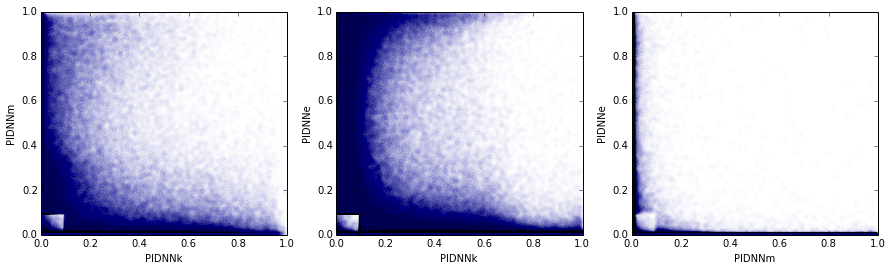

In [26]:
figure(figsize=[15, 4])
for i, (feature1, feature2) in enumerate(combinations(['PIDNNk', 'PIDNNm', 'PIDNNe'], 2)):
    subplot(1, 3, i + 1)
    scatter(data_sw_passed[feature1].values, data_sw_passed[feature2].values, alpha=0.01)
    xlabel(feature1)
    ylabel(feature2)
    ylim(0, 1), xlim(0, 1)
plt.savefig('img/PID_selected.png' , format='png')

## pt

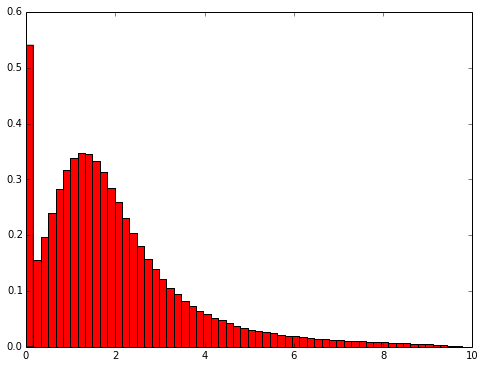

In [27]:
hist(data_sw_passed.diff_pt.values, bins=60, normed=True)
pass

## count of tracks

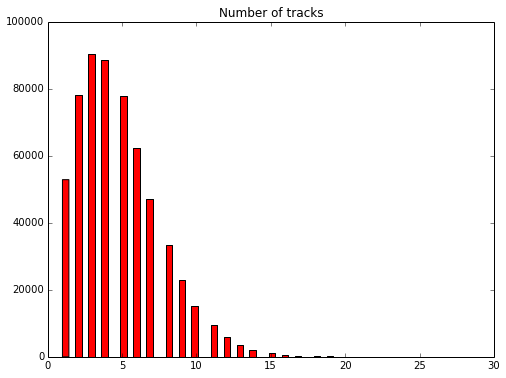

In [28]:
_, n_tracks = numpy.unique(data_sw_passed[event_id_column], return_counts=True)
hist(n_tracks, bins=60)    
title('Number of tracks')
plt.savefig('img/tracks_number.png' , format='png')

## PIDs histograms

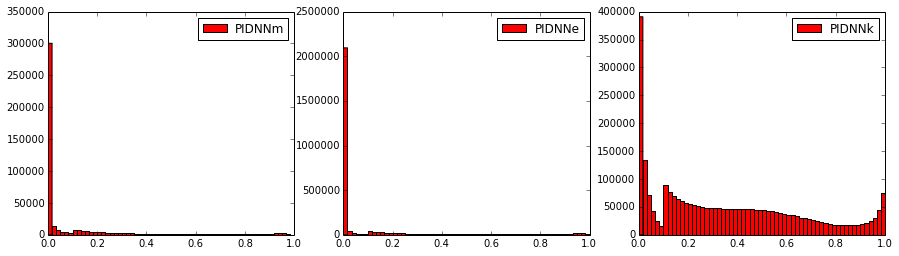

In [29]:
figure(figsize=[15, 4])
for i, column in enumerate(['PIDNNm', 'PIDNNe', 'PIDNNk']):
    subplot(1, 3, i + 1)
    hist(data_sw_passed[column].values, bins=60, range=(0, 1), label=column)
    legend()

In [30]:
! free -m

             total       used       free     shared    buffers     cached
Mem:        100721      67529      33192          0        533      23568
-/+ buffers/cache:      43426      57294
Swap:            0          0          0


##  Preselection of tracks using 2-folding training

In [31]:
base = RandomForestClassifier(n_estimators=300, max_depth=14, min_samples_leaf=100, n_jobs=8)
est_choose_lds = LabeledDataStorage(data_sw_passed, data_sw_passed.label, data_sw_passed.N_sig_sw)
est_choose_RT = FoldingClassifier(base, features=features, random_state=11)
%time est_choose_RT.fit_lds(est_choose_lds)
pass

CPU times: user 3h 17min 15s, sys: 30.2 s, total: 3h 17min 46s
Wall time: 25min 10s


In [32]:
est_choose_report = ClassificationReport({'RF': est_choose_RT}, est_choose_lds)

KFold prediction using folds column


#### ROC AUC

In [33]:
est_choose_report.compute_metric(RocAuc())

OrderedDict([('RF', 0.52832677901065472)])

#### ROC CURVE

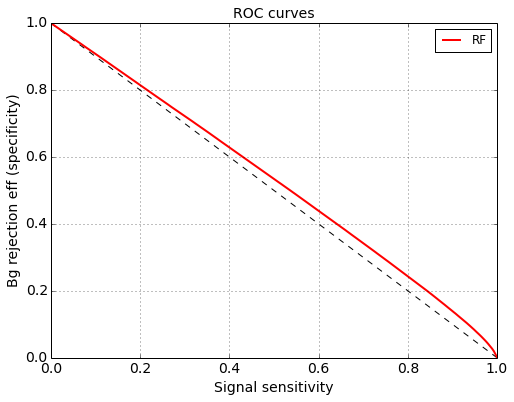

In [34]:
plot([0, 1], [1, 0], 'k--')
est_choose_report.roc()

#### Feature importances

In [35]:
imp = numpy.sum([est.feature_importances_ for est in est_choose_RT.estimators], axis=0)
imp = pandas.DataFrame({'importance': imp / numpy.max(imp), 'feature': est_choose_RT.features})
imp.sort('importance', ascending=False)

,feature,importance
18,IPs,1.000000
16,IP,0.956671
2,partPt,0.945964
9,proj,0.910986
0,cos_diff_phi,0.753124
17,IPerr,0.748064
1,diff_pt,0.707047
5,diff_eta,0.640850
8,sum_PID_mu_k,0.559051
3,partP,0.553785


#### Distributions for output

normalizing distribution with flattener

KFold prediction using folds column


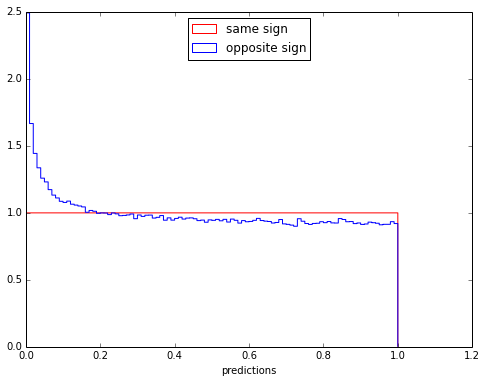

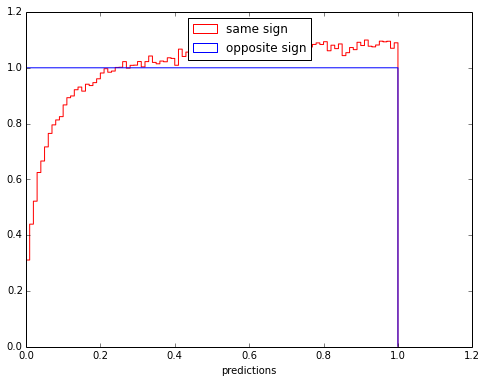

In [36]:
from utils import plot_flattened_probs
probs = est_choose_RT.predict_proba(data_sw_passed)
flat_ss = plot_flattened_probs(probs, data_sw_passed.label.values, data_sw_passed.N_sig_sw.values, label=1)
flat_os = plot_flattened_probs(probs, data_sw_passed.label.values, data_sw_passed.N_sig_sw.values, label=0)

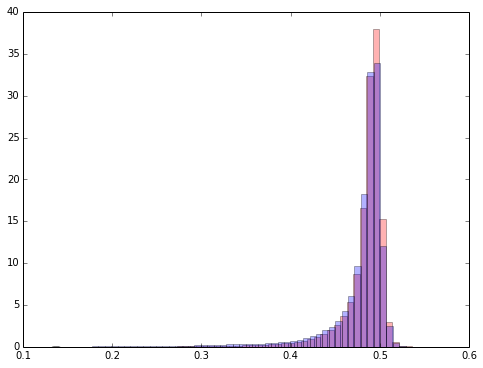

In [37]:
hist(probs[:, 1][data_sw_passed.label.values == 1], bins=60, alpha=0.3, normed=True)
hist(probs[:, 1][data_sw_passed.label.values == 0], bins=60, alpha=0.3, normed=True)
pass

----

## Train to distinguish same sign vs opposite sign

In [42]:
from rep_ef.estimators import MatrixNetSkyGridClassifier
from hep_ml.decisiontrain import DecisionTrainClassifier
from hep_ml.losses import LogLossFunction

In [43]:
data_sw_passed_lds = LabeledDataStorage(data_sw_passed, data_sw_passed.label, data_sw_passed.N_sig_sw.values)

### DT

In [44]:
tt_base = DecisionTrainClassifier(learning_rate=0.02, n_estimators=3000, depth=6, pretransform_needed=True, 
                                  max_features=15, loss=LogLossFunction(regularization=100))
tt_folding = FoldingClassifier(tt_base, n_folds=2, random_state=11, ipc_profile='ssh-ipy', features=features)
%time tt_folding.fit_lds(data_sw_passed_lds)
pass

CPU times: user 4min, sys: 19.6 s, total: 4min 20s
Wall time: 35min 54s


### MN

In [ ]:
mn_base = MatrixNetSkyGridClassifier(connection='skygrid', user_name='antares', 
                                     iterations=3000, regularization=0.02, sync=True)
mn_folding = FoldingClassifier(mn_base, n_folds=2, random_state=11, features=features)

%time mn_folding.fit_lds(data_sw_passed_lds)
pass

In [ ]:
comparison_report = ClassificationReport({'tt': tt_folding, 'mn': mn_folding}, data_sw_passed_lds)

In [ ]:
comparison_report.compute_metric(RocAuc())

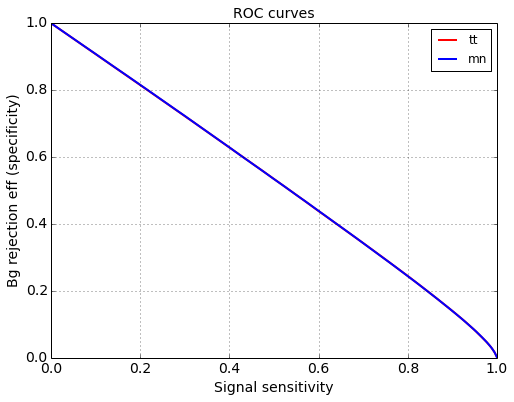

In [49]:
comparison_report.roc()

Default prediction
Default prediction


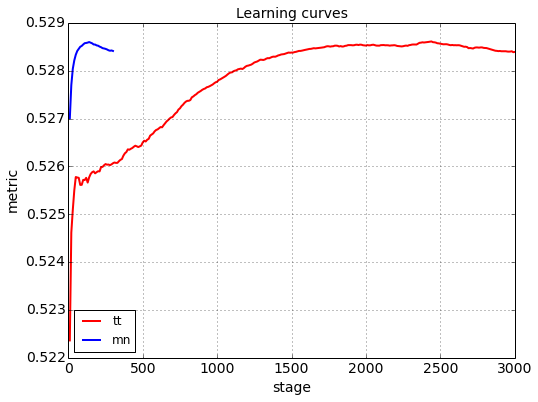

In [50]:
comparison_report.learning_curve(RocAuc(), steps=10)

In [51]:
mn_folding.estimators[0].get_feature_importances().sort('effect', ascending=False)

,effect,efficiency,information
IPs,1.000000,0.797471,0.910096
proj,0.934188,0.746461,0.908301
partPt,0.893961,0.691805,0.937858
IP,0.783372,0.622829,0.912855
max_PID_mu_e,0.496245,0.369815,0.973899
diff_pt,0.492175,0.376002,0.950019
diff_eta,0.418509,0.317583,0.956422
cos_diff_phi,0.417033,0.305866,0.989560
veloch,0.365554,0.286741,0.925261
IPPU,0.319602,0.310995,0.745861


---------

### Forest idea

In [63]:
temp_probs = est_choose_RT.predict_proba(data_sw_passed)[:, 1]
mask = ((flat_ss(temp_probs) < 0.2) & (data_sw_passed.label == 0)) | \
       ((flat_os(temp_probs) > 0.4) & (data_sw_passed.label == 1))

KFold prediction using folds column


In [64]:
base = RandomForestClassifier(n_estimators=300, max_depth=14, min_samples_leaf=100, n_jobs=8)
forest_preselection_lds = LabeledDataStorage(data_sw_passed, mask * 1, data_sw_passed.N_sig_sw)
forest_preselection = FoldingClassifier(base, features=features, random_state=11)
%time forest_preselection.fit_lds(forest_preselection_lds)
pass

CPU times: user 3h 12min 36s, sys: 5.88 s, total: 3h 12min 42s
Wall time: 24min 27s


In [65]:
report = ClassificationReport({'rf': forest_preselection}, forest_preselection_lds)

KFold prediction using folds column


In [66]:
report.compute_metric(RocAuc())

OrderedDict([('rf', 0.61303653103299793)])

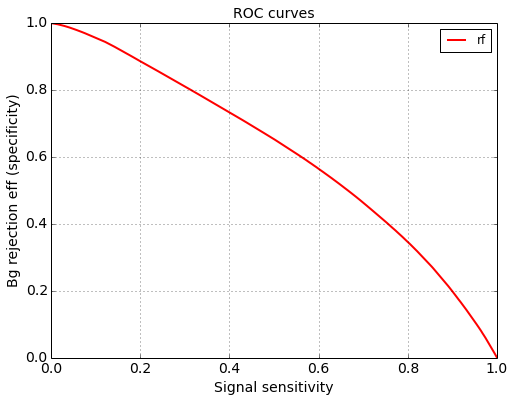

In [67]:
report.roc()

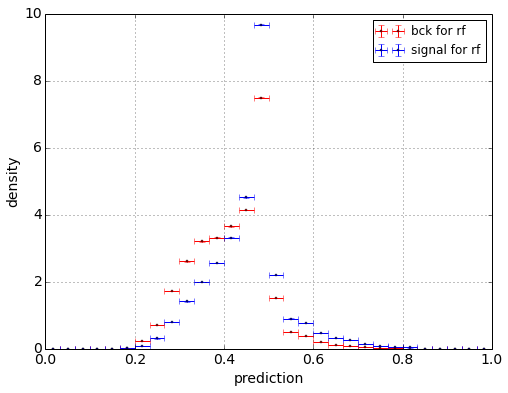

In [68]:
report.prediction_pdf()

In [69]:
prob = forest_preselection.predict_proba(data_sw_passed)[:, 1]
data_sw_passed_preselected = data_sw_passed[prob > 0.5]
data_sw_passed_not_preselected = data_sw_passed[prob <= 0.5]
prob = forest_preselection.predict_proba(data_sw_not_passed)[:, 1]
data_sw_not_passed_preselected = data_sw_not_passed[prob > 0.5]

KFold prediction using folds column
KFold prediction using folds column


In [70]:
get_events_statistics(data_sw_passed_preselected)

{'Events': 266771, 'tracks': 372254}

In [71]:
data_sw_passed_preselected_lds = LabeledDataStorage(data_sw_passed_preselected, data_sw_passed_preselected.label, 
                                                    sample_weight=data_sw_passed_preselected.N_sig_sw.values)

In [72]:
tt_base = DecisionTrainClassifier(learning_rate=0.02, n_estimators=3000, depth=6, pretransform_needed=True, 
                                  max_features=15, loss=LogLossFunction(regularization=100))
tt_folding_preselected = FoldingClassifier(tt_base, n_folds=2, random_state=11, 
                                           ipc_profile='ssh-ipy', features=features)
%time tt_folding_preselected.fit_lds(data_sw_passed_preselected_lds)
pass

CPU times: user 23.4 s, sys: 1.64 s, total: 25 s
Wall time: 3min 19s


KFold prediction using folds column
Default prediction


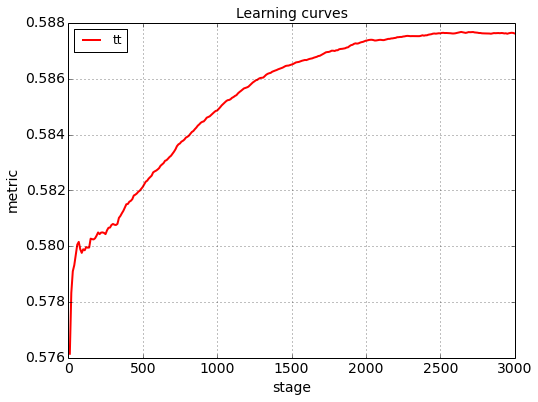

In [73]:
report = ClassificationReport({'tt': tt_folding_preselected}, data_sw_passed_preselected_lds)
report.learning_curve(RocAuc())

--------

# Calibration

In [52]:
from utils import get_result_with_bootstrap_for_given_part

In [53]:
models = []

KFold prediction using folds column
KFold prediction using folds column


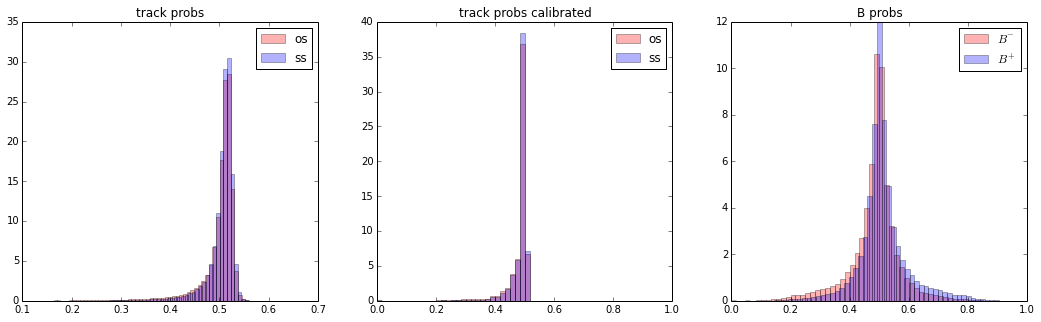

AUC for tagged: 0.604997814127 AUC with untag: 0.602393343505
mean AUC after calibration: 0.604922974946 5.83943406852e-07


In [54]:
models.append(get_result_with_bootstrap_for_given_part(tagging_efficiency, tagging_efficiency_delta, tt_folding, 
                                                      [data_sw_passed, data_sw_not_passed], 'tt-iso', logistic=False))

KFold prediction using folds column
KFold prediction using folds column


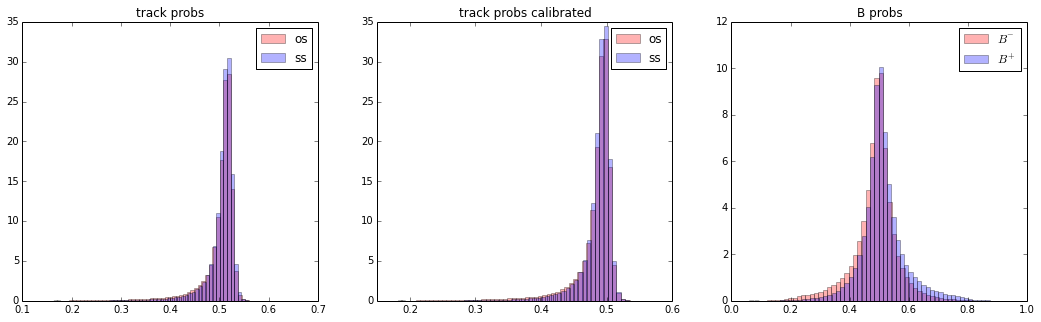

AUC for tagged: 0.604604920728 AUC with untag: 0.601993594358
mean AUC after calibration: 0.604608728286 3.05863373928e-07


In [ ]:
models.append(get_result_with_bootstrap_for_given_part(tagging_efficiency, tagging_efficiency_delta, tt_folding, 
                                                      [data_sw_passed, data_sw_not_passed], 'tt-log', logistic=True))

KFold prediction using folds column
KFold prediction using folds column


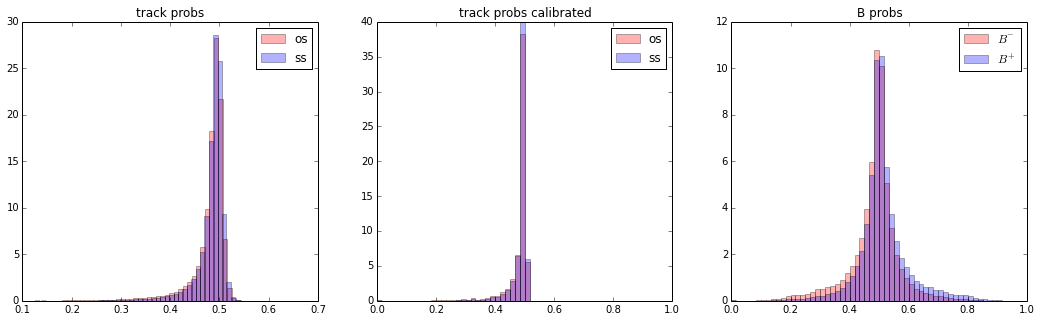

In [ ]:
models.append(get_result_with_bootstrap_for_given_part(tagging_efficiency, tagging_efficiency_delta, mn_folding, 
                                                      [data_sw_passed, data_sw_not_passed], 'mn-iso', logistic=False))

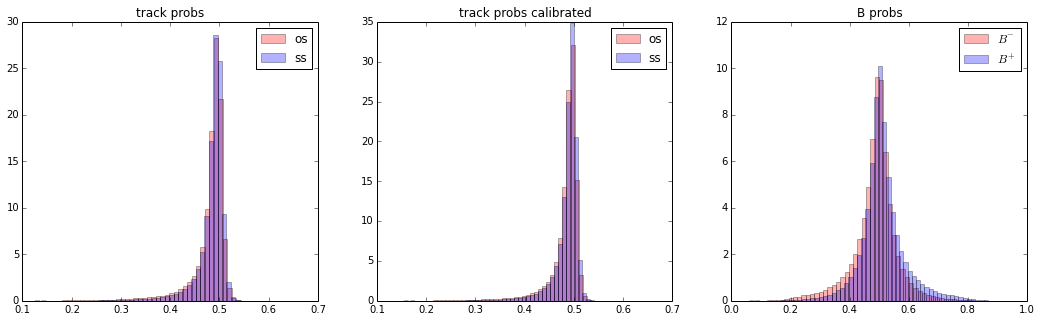

In [ ]:
models.append(get_result_with_bootstrap_for_given_part(tagging_efficiency, tagging_efficiency_delta, mn_folding, 
                                                      [data_sw_passed, data_sw_not_passed], 'mn-log', logistic=True))

KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column


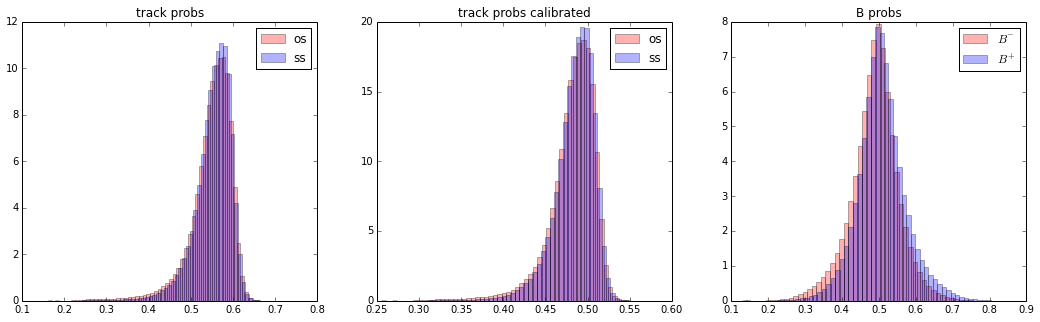

AUC for tagged: 0.591525551837 AUC with untag: 0.589312518694
mean AUC after calibration: 0.591711734251 6.57787571905e-07


In [74]:
models.append(get_result_with_bootstrap_for_given_part(tagging_efficiency,
                                                       tagging_efficiency_delta, 
                                                       tt_folding_preselected, 
                                                      [data_sw_passed_preselected, data_sw_passed_not_preselected,
                                                       data_sw_not_passed], 
                                                       'forest-idea-tt-log', logistic=True))

## Comparison table of different models

In [75]:
pandas.set_option('display.precision', 8)
result = pandas.concat(models)
result.index = result.name
result.drop('name', axis=1)

,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
name,,,,,,,,
tt-iso,96.5254294,0.1139896,0.0368152,0.0004975,3.5535993,0.0482086,60.2393344,0
tt-log,96.5254294,0.1139896,0.0376464,0.0003300,3.6338391,0.0321443,60.1993594,0
mn-iso,96.5254294,0.1139896,0.0369129,0.0004683,3.5630371,0.0454016,60.2344854,0
mn-log,96.5254294,0.1139896,0.0377376,0.0004013,3.6426378,0.0389775,60.1859025,0
forest-idea-tt-log,96.5254294,0.1139896,0.0286758,0.0003687,2.7679465,0.0357377,58.9312519,0


--------------------------

## Implementing best tracking

In [60]:
from utils import prepare_B_data_for_given_part

KFold prediction using folds column
KFold prediction using folds column


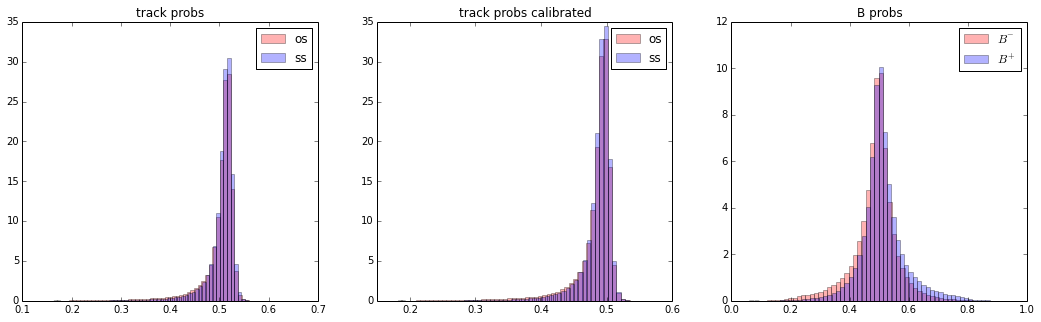

AUC for tagged: 0.604604920728 AUC with untag: 0.601993594358


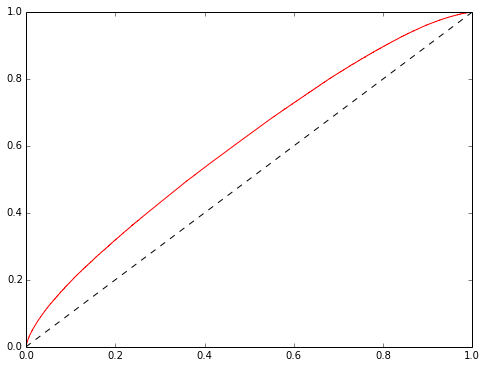

In [61]:
Bdata_prepared = prepare_B_data_for_given_part(tt_folding, [data_sw_passed, data_sw_not_passed], logistic=True)

In [62]:
Bdata_prepared.to_csv('models/Bdata_tracks_PID_less.csv', header=True, index=False)